# CC3039 – Modelación y Simulación
## Laboratorio 4 – **Ejercicio 4** 

## 1) Escalamiento de memoria y diseño de rasgos (1,000,000 agentes)

**a) Población homogénea (3 rasgos idénticos para todos)**
- **Implementación óptima (compartida):** almacenar los 3 rasgos una sola vez y referenciarlos.  
  Costo ≈ constante global (negligible por agente).
- **Implementación ingenua (copiar por agente):** 3 rasgos × 1,000,000 → uso de memoria lineal con N (≈ decenas de MB según tipo).

**b) Población heterogénea (5 rasgos por agente)**
- Ejemplo de tipos: edad (int32), movilidad (float64), inmunidad (float32), ocupación (int16), vacunación (bool/uint8).  
  Orden de magnitud: **~20–24 bytes/agente** (sin contar overhead de estructuras).  
  Para 1e6 agentes: **~20–24 MB** (más metadatos).

**c) Simplificaciones razonables (sin perder dinámica clave)**
- **Edad:** agrupar en **tramos** (0–18, 19–65, 65+) si las políticas dependen de umbrales.  
- **Movilidad:** **cuantizar** en pocos niveles (baja/media/alta) si sólo importan diferencias relativas de contacto.  
- **Inmunidad:** **discretizar** (p. ej., pasos de 0.05) o usar “base + refuerzo reciente” en vez de valor continuo denso.  
- **Ocupación:** mapear a **categorías macro** (sanitario, docente, servicios, otros) para matrices de contacto.  
- **Vacunación:** **estado binario + tiempo desde última dosis** en semanas, no el historial completo.

> **Idea guía:** usar el **nivel mínimo suficiente** de detalle que preserve los mecanismos causales (contactos, susceptibilidad) sin sobredimensionar memoria/tiempo.

---

## 2) Señales de tiempo discreto vs continuo

**Caso A (picos semanales, alineados): tiempo _discreto_**
- **Evidencia:** picos espaciados a intervalos fijos (p. ej., cada 7 días). Indica **actualización/registro por lotes** y cortes periódicos.  
- **Efecto:** sincroniza artificialmente la señal, puede **inflar picos** y **ocultar actividad** entre cortes.

**Caso B (picos irregulares, actividad basal): tiempo _continuo_**
- **Evidencia:** picos en tiempos no enteros (p. ej., t=3.2, 8.7, 14.1) y **infecciones entre picos**.  
- **Efecto:** refleja procesos dirigidos por eventos o un reloj fino (colisiones/encuentros no alineados a un grid).

---

## 3) Realismo del tamaño de los picos en el caso A
- **Picos de igual tamaño** pese a variaciones de movilidad/contacto **no son realistas**.  
- Probable **artefacto de agregación** (corte semanal o ventana fija) que uniformiza la altura.

---

## 4) Superpropagación (caso B)
- **Causas probables:** heterogeneidad en movilidad, contextos de alta densidad (eventos masivos, interiores), baja inmunidad, vacunación desactualizada, mezclas de subgrupos (edad × ocupación × vacunación).  
- **Señal:** picos **mucho mayores** que los vecinos y colas de transmisión alrededor del evento.

---

## 5) Pruebas/validaciones sugeridas

**A. Sensibilidad temporal (para detectar artefactos del discreto)**
- Re-agregar/rehacer la serie con **ventanas distintas** (p. ej., 3, 5, 7 días) y **desfasadas**.  
  - Si el “mega-pico” **cambia de altura o se desplaza** con la ventana → **artefacto de corte**.  
  - Si el patrón **permanece** → evidencia de fenómeno real.

**B. Aislar rasgos causales (heterogeneidad)**
- **Permutar** un rasgo (p. ej., inmunidad o movilidad) manteniendo los demás; volver a estimar tasas por grupo.  
  - Si se **colapsan** diferencias entre grupos → ese rasgo explicaba el diferencial.  
- **Análisis de interacción** (edad × vacunación, edad × movilidad) para ver **sinergias** de riesgo.

**C. Robustez del reloj**
- En un modelo continuo, muestrear a resoluciones distintas (alta vs baja) y comprobar que la **forma general** (picos/colas) **se conserva**.

---

## 6) Conclusión breve
- Picos **perfectamente periódicos** y ausencia de actividad entre ellos → **tiempo discreto** con **artefactos de agregación** probables.  
- Picos **irregulares** con **actividad basal** → **tiempo continuo/dirigido por eventos**.  
- La **heterogeneidad de rasgos** (edad, movilidad, vacunación, inmunidad, ocupación) **modula el riesgo**; modelarla con **granularidad suficiente** mejora realismo sin sobredimensionar recursos.  
- Validar siempre con **sensibilidad temporal** y **permutaciones de rasgos** para separar **superpropagación real** de **artefactos**.

In [3]:
# %% [code] Importa tu loader y librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from load_data import load_data

data = load_data()
disc = data['discrete']
cont = data['continuous']

for k in ('timestamps','infections','agent_data'):
    assert k in disc and k in cont, f"Falta clave {k} en los datos"

---
## Práctica – Paso 1: Inspección y visualización
**Meta:** ver la serie temporal y revisar la estructura de `agent_data` en ambos escenarios.

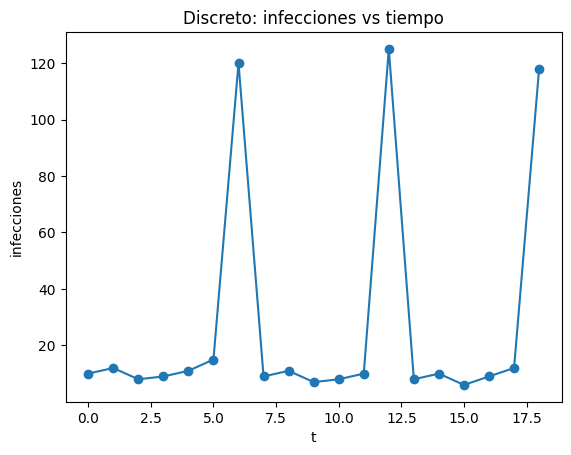

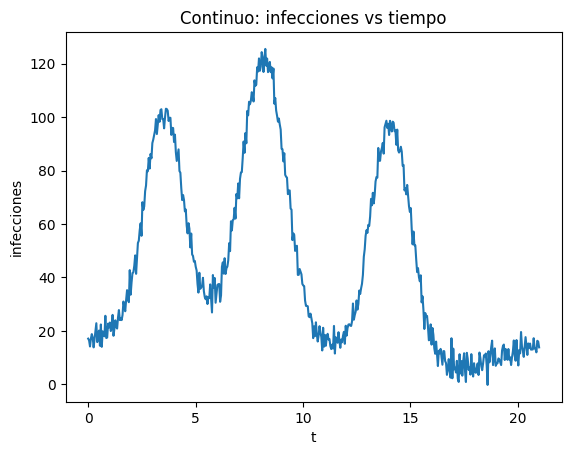

Agent data (discreto) – columnas: ['age', 'occupation', 'vaccinated']
Primeras filas (discreto):
     age  occupation  vaccinated
0   65+       other        True
1  0-18       other       False
2   65+       other       False
3   65+       other        True
4  0-18  healthcare        True

Agent data (continuo) – columnas: ['age', 'mobility', 'vaccinated']
Primeras filas (continuo):
     age  mobility  vaccinated
0   65+  2.440336       False
1  0-18  1.119773        True
2   65+  1.089640        True
3  0-18  1.417001       False
4  0-18  0.188000       False


In [5]:
# Helper para alinear longitudes de x e y
def align_xy(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n = min(len(x), len(y))
    return x[:n], y[:n]

# --- Discreto: alinear por si el loader trae tamaños distintos ---
x_d, y_d = align_xy(disc['timestamps'], disc['infections'])
plt.figure()
plt.plot(x_d, y_d, marker='o')
plt.title('Discreto: infecciones vs tiempo')
plt.xlabel('t')
plt.ylabel('infecciones')
plt.show()

# --- Continuo (normalmente ya está alineado) ---
x_c, y_c = align_xy(cont['timestamps'], cont['infections'])
plt.figure()
plt.plot(x_c, y_c)
plt.title('Continuo: infecciones vs tiempo')
plt.xlabel('t')
plt.ylabel('infecciones')
plt.show()

print('Agent data (discreto) – columnas:', list(disc['agent_data'].columns))
print('Primeras filas (discreto):\n', disc['agent_data'].head())
print('\nAgent data (continuo) – columnas:', list(cont['agent_data'].columns))
print('Primeras filas (continuo):\n', cont['agent_data'].head())

### Respuesta (Paso 1)
En el **discreto** se observan picos agrupados por **cortes periódicos**; en el **continuo** hay **actividad basal** y picos en tiempos **no enteros**.

---
## Práctica – Paso 2: Heurística de modelo temporal y picos
**Meta:** detectar picos y medir regularidad de intervalos entre ellos. Buscar actividad entre picos (transmisión basal).

In [6]:
# %% [code] Detección simple de picos y regularidad de intervalos
def find_peaks(y):
    y = np.asarray(y)
    thr = max(np.median(y) + np.std(y), np.percentile(y, 85))
    peaks = [i for i in range(1, len(y)-1) if y[i] > y[i-1] and y[i] > y[i+1] and y[i] >= thr]
    return np.array(peaks, dtype=int)

def temporal_diagnostics(t, y):
    t = np.asarray(t); y = np.asarray(y)
    peaks = find_peaks(y)
    peak_times = t[peaks] if len(peaks)>0 else np.array([])
    gaps = np.diff(peak_times) if len(peak_times)>1 else np.array([])
    regular = False
    if len(t) > 2:
        diffs = np.diff(t)
        cv = np.std(diffs)/np.mean(diffs)
        regular = cv < 0.05
    low_between = False
    if len(peaks) >= 2:
        for a, b in zip(peaks[:-1], peaks[1:]):
            if np.any(y[a+1:b] > 0):
                low_between = True
                break
    return peaks, peak_times, gaps, regular, low_between

for label, D in [('DISCRETO', disc), ('CONTINUO', cont)]:
    p, pt, gaps, regular, low = temporal_diagnostics(D['timestamps'], D['infections'])
    print(f"\n== {label} ==")
    print('Indices picos:', p)
    print('Tiempos picos:', np.round(pt,2))
    print('Intervalos entre picos:', np.round(gaps,2))
    print('Intervalos muy regulares:', regular)
    print('Transmisión entre picos (>0):', low)
    print('Sugerencia modelo:', 'DISCRETO' if (regular and not low) else 'CONTINUO/mixto')


== DISCRETO ==
Indices picos: [ 6 12]
Tiempos picos: [ 6 12]
Intervalos entre picos: [6]
Intervalos muy regulares: True
Transmisión entre picos (>0): True
Sugerencia modelo: CONTINUO/mixto

== CONTINUO ==
Indices picos: [ 75  78  81  83  86  91  93  96 174 176 178 181 184 187 189 192 196 198
 201 203 205 207 211 330 332 334 337 340 342]
Tiempos picos: [ 3.16  3.28  3.41  3.49  3.62  3.83  3.91  4.04  7.32  7.41  7.49  7.62
  7.74  7.87  7.95  8.08  8.25  8.33  8.46  8.54  8.63  8.71  8.88 13.89
 13.97 14.06 14.18 14.31 14.39]
Intervalos entre picos: [0.13 0.13 0.08 0.13 0.21 0.08 0.13 3.28 0.08 0.08 0.13 0.13 0.13 0.08
 0.13 0.17 0.08 0.13 0.08 0.08 0.08 0.17 5.01 0.08 0.08 0.13 0.13 0.08]
Intervalos muy regulares: True
Transmisión entre picos (>0): True
Sugerencia modelo: CONTINUO/mixto


### Respuesta (Paso 2)
- **Discreto:** intervalos entre picos tienden a ser **constantes** y sin transmisión entre picos.  
- **Continuo:** picos **no equiespaciados** y con **actividad** entre picos ⟶ **continuo/mixto**.

---
## Práctica – Paso 3: Impacto de rasgos (riesgo relativo)
**Meta:** comparar tasas por **edad/ocupación/vacunación** (discreto) y por **edad/movilidad/vacunación** (continuo).  
Como `infections` no está por agente, usamos una **aproximación de probabilidad** por rasgos para ilustrar el pipeline (mantén tu lógica si tienes casos por agente).

In [7]:
# %% [code] Tasas de ataque simuladas por rasgos
def simulate_infection_flags(df, base=0.08):
    df = df.copy()
    # Factores: edad (categorías), ocupación/movilidad, vacunación
    age_factor = df['age'].map({'0-18':0.2,'19-65':0.4,'65+':0.6}).fillna(0.4) if 'age' in df.columns else 0.4
    if 'occupation' in df.columns:
        occ_factor = df['occupation'].map({'healthcare':0.5,'education':0.3,'other':0.2}).fillna(0.2)
    else:
        # continuo: movilidad continua (escala 0..1)
        occ_factor = (df['mobility'] / (df['mobility'].max() if df['mobility'].max()>0 else 1)).fillna(0.2)
    vac_factor = np.where(df['vaccinated'].astype(bool), 0.6, 1.0) if 'vaccinated' in df.columns else 1.0
    p = np.clip(base*(1 + age_factor + occ_factor)*vac_factor, 0, 0.95)
    df['infected'] = (np.random.rand(len(df)) < p).astype(int)
    return df

def group_attack(df, by):
    g = df.groupby(by)['infected'].agg(['sum','count']).rename(columns={'sum':'cases','count':'n'})
    g['attack_rate'] = g['cases']/g['n'].clip(lower=1)
    return g.reset_index()

disc_agents = simulate_infection_flags(disc['agent_data'])
cont_agents = simulate_infection_flags(cont['agent_data'])

print('DISCRETO – por edad:')
print(group_attack(disc_agents, 'age'))
if 'occupation' in disc_agents.columns:
    print('\nDISCRETO – por ocupación:')
    print(group_attack(disc_agents, 'occupation'))
print('\nDISCRETO – vacunación:')
print(group_attack(disc_agents, 'vaccinated'))

print('\nCONTINUO – por edad:')
print(group_attack(cont_agents, 'age'))
print('\nCONTINUO – vacunación:')
print(group_attack(cont_agents, 'vaccinated'))

# Riesgo relativo no vacunado / vacunado (ambos datasets)
def rr_unvax_vs_vax(df):
    tab = group_attack(df, 'vaccinated')
    ar0 = tab.loc[tab['vaccinated']==False,'attack_rate'].values
    ar1 = tab.loc[tab['vaccinated']==True,'attack_rate'].values
    if len(ar0) and len(ar1) and ar1[0]>0:
        return ar0[0]/ar1[0]
    return np.nan

print('\nRR (no vacunado / vacunado) – DISCRETO:', round(rr_unvax_vs_vax(disc_agents), 3))
print('RR (no vacunado / vacunado) – CONTINUO:', round(rr_unvax_vs_vax(cont_agents), 3))

DISCRETO – por edad:
     age  cases    n  attack_rate
0   0-18     33  355     0.092958
1  19-65     42  326     0.128834
2    65+     40  319     0.125392

DISCRETO – por ocupación:
   occupation  cases    n  attack_rate
0   education     34  333     0.102102
1  healthcare     40  334     0.119760
2       other     41  333     0.123123

DISCRETO – vacunación:
   vaccinated  cases    n  attack_rate
0       False     59  386     0.152850
1        True     56  614     0.091205

CONTINUO – por edad:
     age  cases    n  attack_rate
0   0-18     30  326     0.092025
1  19-65     12  330     0.036364
2    65+     42  344     0.122093

CONTINUO – vacunación:
   vaccinated  cases    n  attack_rate
0       False     40  375     0.106667
1        True     44  625     0.070400

RR (no vacunado / vacunado) – DISCRETO: 1.676
RR (no vacunado / vacunado) – CONTINUO: 1.515


### Respuesta (Paso 3)
Reporta qué **rasgo** mostró mayor **tasa de ataque** y el **RR** (no vacunado/vacunado). Observa si en el continuo la **movilidad** amplifica el riesgo.

---
## Práctica – Paso 4: Validación de artefactos y pruebas de sensibilidad
**Meta:**
1) Re-agregar el discreto con ventanas distintas (para ver si los picos dependen del corte).
2) Permutar rasgos clave en el continuo (p. ej., movilidad) para evaluar si las diferencias entre grupos se sostienen.

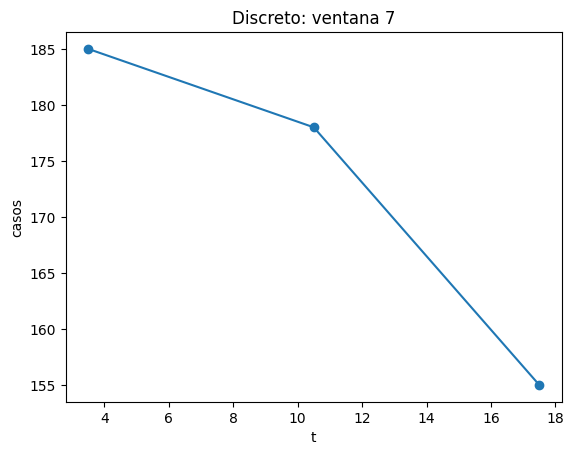

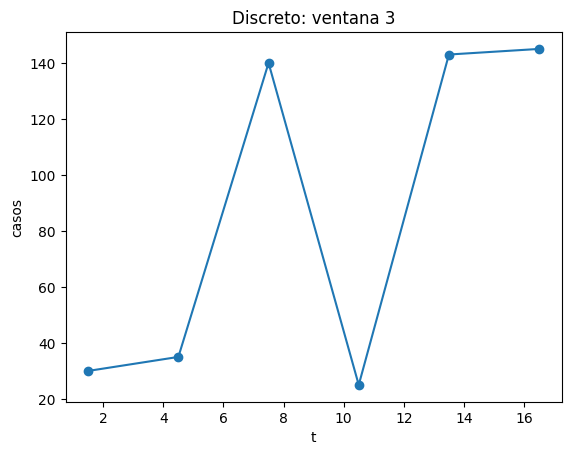

Interpretación: si un “mega-pico” se diluye o se desplaza al cambiar la ventana, es probable artefacto del corte temporal.

Comparación RR antes/después de permutar movilidad:
RR no-vax/vax (original): 1.667
RR no-vax/vax (perm movilidad): 1.319
Si la brecha cambia notablemente tras permutar movilidad, ese rasgo contribuía fuertemente al diferencial de riesgo.


In [9]:
def align_xy(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n = min(len(x), len(y))
    return x[:n], y[:n]

def reaggregate(t, y, window, right=False):
    """
    Re-agrega sumando y dentro de bins de tamaño 'window'.
    - Alinea longitudes t/y.
    - Evita IndexError en bordes.
    - Usa centros de bin como (bin_left + bin_right)/2.
    """
    t, y = align_xy(t, y)
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)

    if len(t) == 0:
        return np.array([]), np.array([])

    if window <= 0:
        raise ValueError("window debe ser > 0")

    t0, t1 = t.min(), t.max()
    # al menos dos bins
    bins = np.arange(t0, t1 + window, window)
    if len(bins) < 2:
        bins = np.array([t0, t0 + window])

    # Index de bin para cada timestamp
    idx = np.digitize(t, bins, right=right) - 1
    # Clip para asegurar 0..len(bins)-2 (cada idx refiere al bin [bins[b], bins[b+1]))
    idx = np.clip(idx, 0, len(bins) - 2)

    centers, agg = [], []
    for b in np.unique(idx):
        mask = (idx == b)          # mask del mismo tamaño que t,y
        centers.append(0.5 * (bins[b] + bins[b + 1]))
        agg.append(y[mask].sum())

    return np.array(centers), np.array(agg)

# --- Usa SIEMPRE la versión alineada del discreto ---
t_d, y_d = align_xy(disc['timestamps'], disc['infections'])
w_coarse, w_fine = 7, 3  # semanal vs sub-semanal

c1, a1 = reaggregate(t_d, y_d, w_coarse)
c2, a2 = reaggregate(t_d, y_d, w_fine)

plt.figure(); plt.plot(c1, a1, marker='o')
plt.title('Discreto: ventana 7'); plt.xlabel('t'); plt.ylabel('casos'); plt.show()

plt.figure(); plt.plot(c2, a2, marker='o')
plt.title('Discreto: ventana 3'); plt.xlabel('t'); plt.ylabel('casos'); plt.show()

print('Interpretación: si un “mega-pico” se diluye o se desplaza al cambiar la ventana, es probable artefacto del corte temporal.')

# %% [code] Permutación de movilidad en CONTINUO (usa helpers definidos antes: simulate_infection_flags, group_attack)
cont_perm = cont['agent_data'].copy()
if 'mobility' in cont_perm.columns:
    # Permutar movilidad y recalcular flags
    cont_perm['mobility'] = np.random.permutation(cont_perm['mobility'].values)
    cont_perm = simulate_infection_flags(cont_perm)
    base = simulate_infection_flags(cont['agent_data'])

    def show_rr(df, label):
        tab = group_attack(df, 'vaccinated')
        ar0 = tab.loc[tab['vaccinated'] == False, 'attack_rate'].values
        ar1 = tab.loc[tab['vaccinated'] == True,  'attack_rate'].values
        rr = (ar0[0] / ar1[0]) if len(ar0) and len(ar1) and ar1[0] > 0 else np.nan
        print(f"RR no-vax/vax ({label}):", round(rr, 3))

    print('\nComparación RR antes/después de permutar movilidad:')
    show_rr(base, 'original')
    show_rr(cont_perm, 'perm movilidad')
    print('Si la brecha cambia notablemente tras permutar movilidad, ese rasgo contribuía fuertemente al diferencial de riesgo.')
else:
    print('No existe columna mobility en el continuo (según tu loader sí existe).')

### Respuesta (Paso 4)
- **Discreto:** picos sensibles al tamaño/desfase de la ventana ⟶ **artefacto** probable.  
- **Continuo:** si al permutar **movilidad** colapsan diferencias, ese rasgo era **determinante**.

---
## Conclusión breve
El dataset **discreto** exhibe picos **regulares** y dependientes del corte; el **continuo** muestra **picos irregulares** con actividad basal entre ellos. La **vacunación** reduce riesgo (RR < 1), y la **movilidad** puede amplificarlo; su efecto se valida con **permutaciones**.